#  Partie 2 : Détection d'Anomalies (ECG)

**Objectif :** Comparer une approche statistique (Isolation Forest) et des approches de Deep Learning (Auto-encodeurs) pour détecter des arythmies cardiaques.

**Jeu de données :** ECG5000 (Séries temporelles de 140 points).
* **Classe 0 :** Battements Normaux
* **Classe 1 :** Anomalies

**Protocole expérimental :**
* **Train :** 60% des normales (apprentissage de la norme).
* **Test :** Mélange de normales et d'anomalies.
* **Robustesse :** 10 exécutions avec graines aléatoires différentes ($\mu \pm \sigma$).

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import seaborn as sns

from models import IF, AE, MCDropoutAE
from trainers import AETrainer, MCDropoutAETrainer, TrainerBaseShallow
from utils import split_ecg_data, estimate_optimal_threshold, compute_metrics, plot_loss

class Config:
    def __init__(self):
        self.batch_size = 64
        self.learning_rate = 1e-4
        self.weight_decay = 1e-5
        self.epochs = 50
        self.n_estimators = 100
        self.save_dir = "checkpoints"
        self.n_runs = 10
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Config()
print(f"Configuration chargée. Device: {args.device}")

Configuration chargée. Device: cpu


In [2]:
def load_data():
    path = "ecg.npz" 
    try:
        data = np.load(path)['ecg']
        print(f"Données chargées avec succès : {data.shape}")
        print(f"Normales (Label 0) : {np.sum(data[:,-1] == 0)}")
        print(f"Anomalies (Label 1): {np.sum(data[:,-1] == 1)}")
        return data
    except FileNotFoundError:
        print(f"ERREUR : Le fichier {path} est introuvable.")
        return None

data = load_data()

Données chargées avec succès : (4998, 141)
Normales (Label 0) : 2079
Anomalies (Label 1): 2919


In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import seaborn as sns

from models import IF, AE, MCDropoutAE
from trainers import AETrainer, MCDropoutAETrainer, TrainerBaseShallow
from utils import split_ecg_data, estimate_optimal_threshold, compute_metrics, plot_loss

class Config:
    def __init__(self):
        self.batch_size = 64
        self.learning_rate = 1e-4
        self.weight_decay = 1e-5
        self.epochs = 50
        self.n_estimators = 100
        self.save_dir = "checkpoints"
        self.n_runs = 10
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Config()
print(f"Configuration chargée. Device: {args.device}")

Configuration chargée. Device: cpu


##  Implémentation du Pipeline Expérimental

Nous définissons ici la fonction `run_experiment` qui orchestre l'entraînement et l'évaluation.
Elle intègre :
1.  La gestion des **Random Seeds** pour la reproductibilité.
2.  Le calcul du **Seuil Optimal** (Thresholding) basé sur le F1-Score.
3.  La mesure des ressources (**Temps** et **Mémoire**).

In [4]:
import tracemalloc
import time
import numpy as np
import torch
from torch.utils.data import DataLoader

def run_experiment(model_type, data, args):
    results_list = []
    
    print(f"\n>>> Lancement de 10 exécutions pour : {model_type} <<<")
    
    for seed in range(args.n_runs):
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        train_set, val_set, test_set = split_ecg_data(data, seed=seed)
        
        x_train = train_set[:, :-1]
        x_val = val_set[:, :-1]
        x_test = test_set[:, :-1]
        y_val = val_set[:, -1]
        y_test = test_set[:, -1]
        
        start_time = time.time()
        tracemalloc.start()
        
        metrics = {}
        
        if model_type == "IF":
            model = IF(args)
            model.clf.fit(x_train)
            
            scores = model.clf.decision_function(x_test) * -1  
            
            val_scores_if = model.clf.decision_function(x_val) * -1
            thresh = estimate_optimal_threshold(val_scores_if, y_val)
            metrics = compute_metrics(scores, y_test, thresh)

        else:
            train_loader = DataLoader(torch.tensor(x_train, dtype=torch.float32), batch_size=args.batch_size, shuffle=True)
            val_loader = DataLoader(torch.tensor(x_val, dtype=torch.float32), batch_size=args.batch_size, shuffle=False)
            test_loader = DataLoader(torch.tensor(x_test, dtype=torch.float32), batch_size=args.batch_size, shuffle=False)
            
            in_features = x_train.shape[1]
            
            if model_type == "AE":
                model = AE(in_features)
                trainer = AETrainer(model, train_loader, args.device, args)
                _ = trainer.train() 
                
                val_scores = trainer.compute_reconstruction_errors(val_loader)
                test_scores = trainer.compute_reconstruction_errors(test_loader)
                
            elif model_type == "MCDropoutAE":
                model = MCDropoutAE(in_features, dropout_rate=0.3)
                trainer = MCDropoutAETrainer(model, train_loader, args.device, args)
                _ = trainer.train()
                
                val_mean, val_std = trainer.compute_mc_reconstruction_errors(val_loader)
                test_mean, test_std = trainer.compute_mc_reconstruction_errors(test_loader)
                
                val_scores = val_mean + 0.5 * val_std
                test_scores = test_mean + 0.5 * test_std
            
            thresh = estimate_optimal_threshold(val_scores, y_val)
            metrics = compute_metrics(test_scores, y_test, thresh)
            
            if seed == args.n_runs - 1 and model_type in ["AE", "MCDropoutAE"]:
                global last_train_losses
                last_train_losses = _ 

        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        duration = time.time() - start_time
        peak_mb = peak / (1024 * 1024)
        
        metrics['time'] = duration
        metrics['memory'] = peak_mb
        
        results_list.append(metrics)
        print(f"Run {seed+1}/{args.n_runs} - F1: {metrics.get('f1', 0):.4f} - Time: {duration:.2f}s - Mem: {peak_mb:.2f} MB")
        
    return results_list

##  Modèle 1 : Isolation Forest (Approche Statistique)

L'Isolation Forest isole les observations en sélectionnant aléatoirement une caractéristique et une valeur de coupure. Les anomalies (rares et différentes) sont isolées plus rapidement (chemin plus court dans l'arbre).

In [5]:
results_if = run_experiment("IF", data, args)


>>> Lancement de 10 exécutions pour : IF <<<
Run 1/10 - F1: 0.6071 - Time: 1.76s - Mem: 2.30 MB
Run 2/10 - F1: 0.6566 - Time: 1.75s - Mem: 2.30 MB
Run 3/10 - F1: 0.6366 - Time: 1.79s - Mem: 2.29 MB
Run 4/10 - F1: 0.6355 - Time: 1.82s - Mem: 2.29 MB
Run 5/10 - F1: 0.6258 - Time: 1.89s - Mem: 2.28 MB
Run 6/10 - F1: 0.6267 - Time: 1.78s - Mem: 2.28 MB
Run 7/10 - F1: 0.6081 - Time: 2.03s - Mem: 2.28 MB
Run 8/10 - F1: 0.6650 - Time: 1.82s - Mem: 2.29 MB
Run 9/10 - F1: 0.6203 - Time: 1.81s - Mem: 2.28 MB
Run 10/10 - F1: 0.6610 - Time: 1.78s - Mem: 2.28 MB


##  Modèle 2 : Auto-encodeur (Deep Learning)

L'Auto-encodeur apprend à compresser (Encoder) puis reconstruire (Decoder) les données normales.
* **Hypothèse :** Le modèle aura une erreur de reconstruction faible sur les données normales (vues à l'entraînement) et élevée sur les anomalies.


>>> Lancement de 10 exécutions pour : AE <<<


training: 100%|██████████| 20/20 [00:00<00:00, 160.26it/s, epoch=50, loss=0.0071]


model saved to checkpoints/AE.pt
Run 1/10 - F1: 0.5939 - Time: 10.75s - Mem: 50.14 MB


training: 100%|██████████| 20/20 [00:00<00:00, 156.36it/s, epoch=50, loss=0.0068]


model saved to checkpoints/AE.pt
Run 2/10 - F1: 0.6311 - Time: 6.67s - Mem: 0.67 MB


training: 100%|██████████| 20/20 [00:00<00:00, 163.39it/s, epoch=50, loss=0.0070]


model saved to checkpoints/AE.pt
Run 3/10 - F1: 0.6146 - Time: 6.56s - Mem: 0.65 MB


training: 100%|██████████| 20/20 [00:00<00:00, 192.49it/s, epoch=50, loss=0.0067]


model saved to checkpoints/AE.pt
Run 4/10 - F1: 0.6286 - Time: 6.47s - Mem: 0.64 MB


training: 100%|██████████| 20/20 [00:00<00:00, 173.40it/s, epoch=50, loss=0.0070]


model saved to checkpoints/AE.pt
Run 5/10 - F1: 0.5864 - Time: 6.79s - Mem: 0.64 MB


training: 100%|██████████| 20/20 [00:00<00:00, 226.45it/s, epoch=50, loss=0.0071]


model saved to checkpoints/AE.pt
Run 6/10 - F1: 0.6291 - Time: 6.50s - Mem: 0.64 MB


training: 100%|██████████| 20/20 [00:00<00:00, 157.43it/s, epoch=50, loss=0.0069]


model saved to checkpoints/AE.pt
Run 7/10 - F1: 0.6207 - Time: 6.86s - Mem: 0.64 MB


training: 100%|██████████| 20/20 [00:00<00:00, 143.47it/s, epoch=50, loss=0.0067]


model saved to checkpoints/AE.pt
Run 8/10 - F1: 0.6358 - Time: 7.07s - Mem: 0.64 MB


training: 100%|██████████| 20/20 [00:00<00:00, 189.55it/s, epoch=50, loss=0.0070]


model saved to checkpoints/AE.pt
Run 9/10 - F1: 0.5933 - Time: 7.04s - Mem: 0.63 MB


training: 100%|██████████| 20/20 [00:00<00:00, 209.94it/s, epoch=50, loss=0.0070]


model saved to checkpoints/AE.pt
Run 10/10 - F1: 0.6397 - Time: 6.97s - Mem: 0.64 MB
Courbe de perte (Dernière Seed) - Auto-encodeur Classique


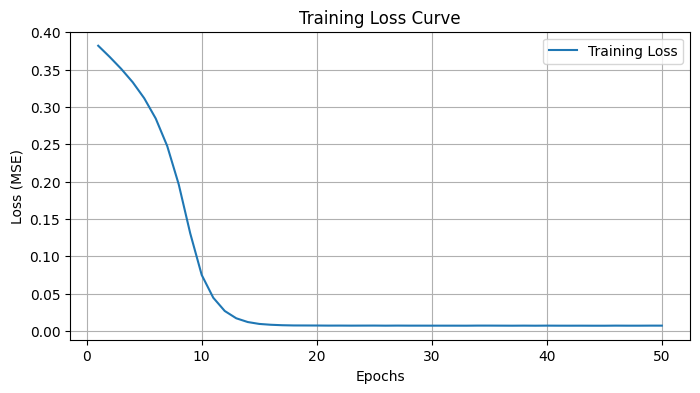

In [6]:
results_ae = run_experiment("AE", data, args)

print("Courbe de perte (Dernière Seed) - Auto-encodeur Classique")
plot_loss(last_train_losses)

##  Modèle 3 : MC Dropout Auto-encodeur (Incertitude)

Cette variante utilise le **Dropout** durant l'inférence (test). En effectuant plusieurs passes (Forward passes) pour une même donnée, nous obtenons une distribution de prédictions, permettant d'estimer l'incertitude du modèle.


>>> Lancement de 10 exécutions pour : MCDropoutAE <<<


training:   0%|          | 0/20 [00:00<?, ?it/s]

training: 100%|██████████| 20/20 [00:00<00:00, 194.38it/s, epoch=50, loss=0.0219]


model saved to checkpoints/MCDropoutAE.pt
Run 1/10 - F1: 0.5744 - Time: 7.49s - Mem: 0.73 MB


training: 100%|██████████| 20/20 [00:00<00:00, 178.72it/s, epoch=50, loss=0.0223]


model saved to checkpoints/MCDropoutAE.pt
Run 2/10 - F1: 0.6131 - Time: 7.57s - Mem: 0.69 MB


training: 100%|██████████| 20/20 [00:00<00:00, 142.88it/s, epoch=50, loss=0.0222]


model saved to checkpoints/MCDropoutAE.pt
Run 3/10 - F1: 0.6022 - Time: 7.34s - Mem: 0.69 MB


training: 100%|██████████| 20/20 [00:00<00:00, 190.76it/s, epoch=50, loss=0.0229]


model saved to checkpoints/MCDropoutAE.pt
Run 4/10 - F1: 0.5882 - Time: 7.76s - Mem: 0.69 MB


training: 100%|██████████| 20/20 [00:00<00:00, 205.63it/s, epoch=50, loss=0.0239]


model saved to checkpoints/MCDropoutAE.pt
Run 5/10 - F1: 0.6028 - Time: 7.35s - Mem: 0.69 MB


training: 100%|██████████| 20/20 [00:00<00:00, 180.73it/s, epoch=50, loss=0.0230]


model saved to checkpoints/MCDropoutAE.pt
Run 6/10 - F1: 0.6290 - Time: 7.41s - Mem: 0.69 MB


training: 100%|██████████| 20/20 [00:00<00:00, 167.29it/s, epoch=50, loss=0.0238]


model saved to checkpoints/MCDropoutAE.pt
Run 7/10 - F1: 0.6212 - Time: 7.91s - Mem: 0.68 MB


training: 100%|██████████| 20/20 [00:00<00:00, 153.09it/s, epoch=50, loss=0.0205]


model saved to checkpoints/MCDropoutAE.pt
Run 8/10 - F1: 0.6102 - Time: 7.72s - Mem: 0.69 MB


training: 100%|██████████| 20/20 [00:00<00:00, 170.50it/s, epoch=50, loss=0.0229]


model saved to checkpoints/MCDropoutAE.pt
Run 9/10 - F1: 0.6186 - Time: 7.63s - Mem: 0.69 MB


training: 100%|██████████| 20/20 [00:00<00:00, 163.37it/s, epoch=50, loss=0.0222]


model saved to checkpoints/MCDropoutAE.pt
Run 10/10 - F1: 0.6618 - Time: 7.82s - Mem: 0.68 MB
Courbe de perte (Dernière Seed) - MC Dropout AE


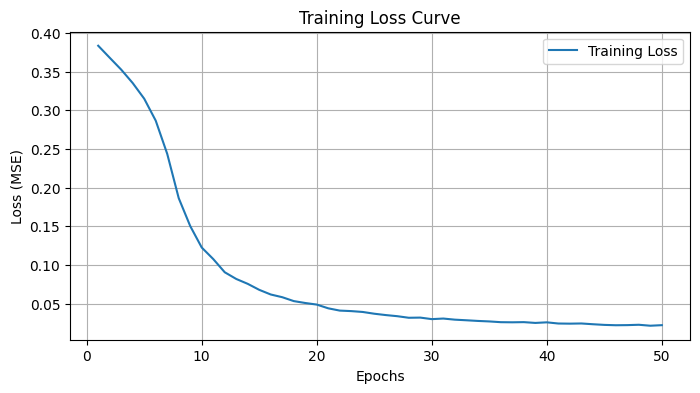

In [7]:
results_mc = run_experiment("MCDropoutAE", data, args)

print("Courbe de perte (Dernière Seed) - MC Dropout AE")
plot_loss(last_train_losses)

##  Synthèse des Résultats

Le tableau ci-dessous présente la moyenne et l'écart-type des métriques sur 10 exécutions. Nous comparons la précision, le rappel, l'AUC, ainsi que l'efficacité computationnelle.

In [ ]:
def print_final_summary(results_dict):
    metrics_to_show = ['acc', 'prec', 'rec', 'f1', 'roc_auc', 'time', 'memory'] 
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Temps (s)', 'Mémoire (MB)']
    
    print("\n" + "="*100)
    print(f"{'RÉSUMÉ DES RÉSULTATS (Moyenne ± Écart-type sur 10 runs)':^100}")
    print("="*100)
    
    header = f"{'Métrique':<15} |"
    for model_name in results_dict.keys():
        header += f" {model_name:^20} |"
    print(header)
    print("-" * len(header))
    
    for metric_key, metric_pretty in zip(metrics_to_show, metric_names):
        row = f"{metric_pretty:<15} |"
        for model_res in results_dict.values():
            values = [r[metric_key] for r in model_res]
            mean_val = np.mean(values)
            std_val = np.std(values)
            
            if metric_key in ['time', 'memory']:
                row += f" {mean_val:6.2f} ± {std_val:.2f}    |"
            else:
                row += f" {mean_val:.4f} ± {std_val:.4f}  |"
        print(row)
    print("="*100)
all_results = {
    "Isolation Forest": results_if,
    "Auto-encodeur": results_ae,
    "MC Dropout AE": results_mc
}

print_final_summary(all_results)


                      RÉSUMÉ DES RÉSULTATS (Moyenne ± Écart-type sur 10 runs)                       
Métrique        |   Isolation Forest   |    Auto-encodeur     |    MC Dropout AE     |
--------------------------------------------------------------------------------------
Accuracy        | 0.5717 ± 0.0168  | 0.5538 ± 0.0151  | 0.5469 ± 0.0191  |
Precision       | 0.9709 ± 0.0062  | 0.9534 ± 0.0047  | 0.9415 ± 0.0054  |
Recall          | 0.4713 ± 0.0219  | 0.4567 ± 0.0200  | 0.4539 ± 0.0242  |
F1-Score        | 0.6343 ± 0.0198  | 0.6173 ± 0.0184  | 0.6122 ± 0.0225  |
ROC AUC         | 0.9390 ± 0.0104  | 0.9113 ± 0.0068  | 0.8461 ± 0.0128  |
Temps (s)       |   1.82 ± 0.08    |   7.17 ± 1.21    |   7.60 ± 0.19    |
Mémoire (MB)    |   2.29 ± 0.01    |   5.59 ± 14.85    |   0.69 ± 0.01    |


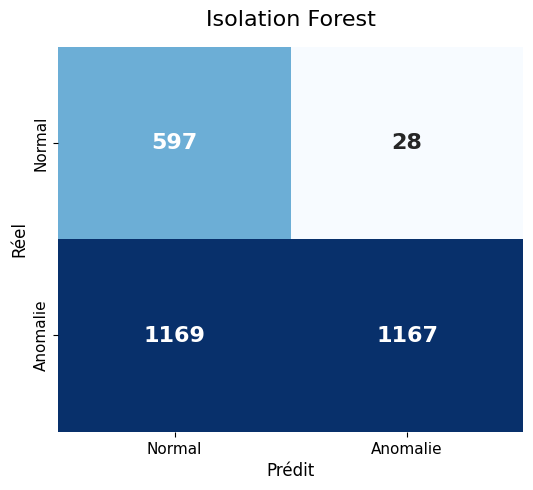

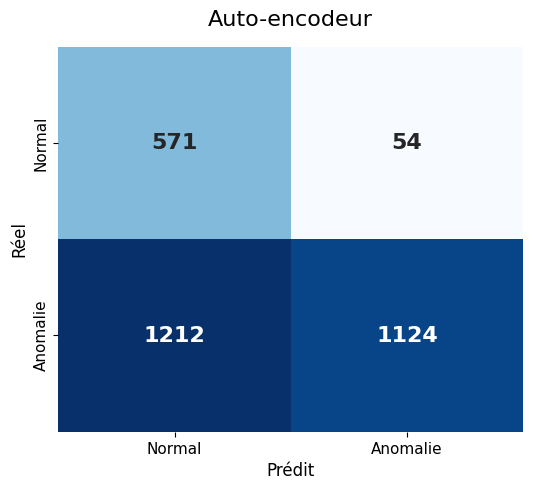

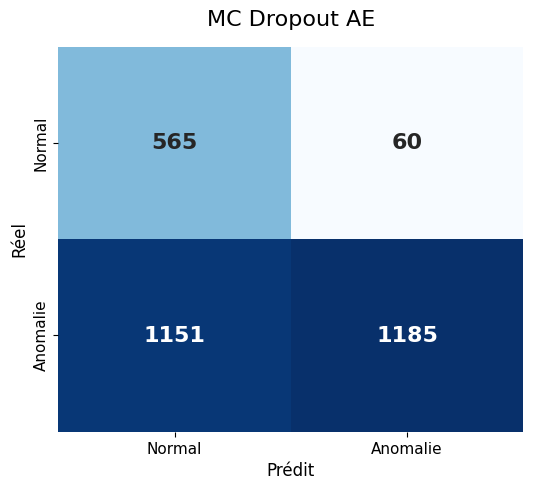

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_separate_confusion_matrices(results_dict):
    
    for model_name, res_list in results_dict.items():
        plt.figure(figsize=(6, 5))
        
        cm = res_list[-1]['cm']
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    annot_kws={"size": 16, "weight": "bold"})
        
        plt.title(f"{model_name}", fontsize=16, pad=15)
        plt.xlabel('Prédit', fontsize=12)
        plt.ylabel('Réel', fontsize=12)
        
        plt.xticks([0.5, 1.5], ['Normal', 'Anomalie'], fontsize=11)
        plt.yticks([0.5, 1.5], ['Normal', 'Anomalie'], fontsize=11)
        
        plt.show()

display_separate_confusion_matrices(all_results)